# ResNet Implementation for CIFAR-10 Classification

This notebook demonstrates how to build and train a ResNet model from scratch for classifying images in the CIFAR-10 dataset using PyTorch. The implementation includes plotting the confusion matrix, accuracy, and loss curve.

In [1]:
#Importing all the required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10
The CIFAR-10 dataset (Canadian Institute for Advanced Research, 10 classes) is a subset of the Tiny Images dataset and consists of 60000 32x32 color images. The images are labelled with one of 10 mutually exclusive classes: airplane, automobile (but not truck or pickup truck), bird, cat, deer, dog, frog, horse, ship, and truck (but not pickup truck). There are 6000 images per class with 5000 training and 1000 testing images per class.
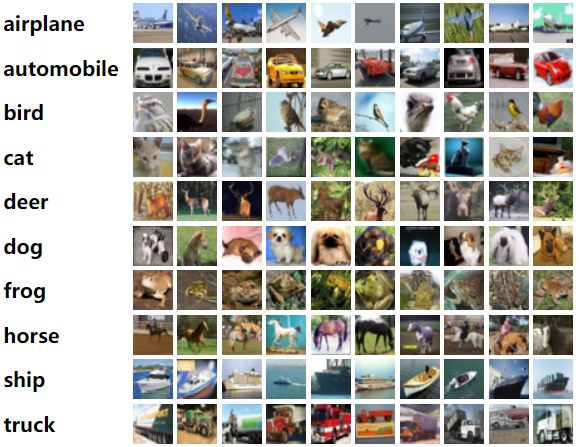

In [ ]:
# Transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

trainloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Skip Connection / Residual Connection
A Skip/Residual connection takes the activations from an (n-1)ᵗʰ convolution layer and adds it to the convolution output of (n+1)ᵗʰ layer and then applies ReLU on this sum, thus Skipping the nᵗʰ layer.

The below diagram explains how a skip connection works. (Here I am using f(x) to denote Relu applied on x where x is the output after applying Convolution operation).


![picture](https://miro.medium.com/v2/resize:fit:786/format:webp/1*negMET6uK7bBLYaqMNpMNg.jpeg)

In [ ]:
import torch.nn as nn

# Define the ResidualBlock class, which inherits from nn.Module
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # Batch normalization after the first convolution
        self.bn1 = nn.BatchNorm2d(out_channels)
        # ReLU activation function
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # Batch normalization after the second convolution
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Define the shortcut connection, initialized as an empty sequential module
        self.shortcut = nn.Sequential()
        # If the stride is not 1 or the input and output channels do not match, adjust the shortcut connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                # 1x1 convolution to match dimensions
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                # Batch normalization after the 1x1 convolution
                nn.BatchNorm2d(out_channels)
            )

    # Define the forward pass
    def forward(self, x):
        # Apply the first convolution, followed by batch normalization and ReLU activation
        out = self.relu(self.bn1(self.conv1(x)))
        # Apply the second convolution, followed by batch normalization
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection to the output (skip connection)
        out += self.shortcut(
        )
        # Apply ReLU activation to the combined output
        out = self.relu(out)
        return out


#Defining the architecture of ResNet
Using the residual blocks that we have defined in the previous code cell, we will define the architecture of the ResNet.

In [ ]:
# Define the ResNet class
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Batch normalization after the initial convolution
        self.bn1 = nn.BatchNorm2d(64)
        # ReLU activation function
        self.relu = nn.ReLU(inplace=True)
        # Define the four layers of ResNet using _make_layer function
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # Adaptive average pooling layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer for classification
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        # Create layers for the block
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the network
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Define a function to create an instance of ResNet-18
def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])


In [ ]:
from torchsummary import summary
# Model
model = ResNet18().to(device)
# Use torchsummary to print a detailed summary
summary(model, (3, 32, 32))
# Hyper-parameters
num_epochs = 20
batch_size = 256
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

# Training Loop

In [ ]:
# Training the model
total_step = len(trainloader)
train_losses = []
test_accuracies = []
# Initialize variables for convergence criterion
best_accuracy = 0.0
no_improvement_count = 0
max_no_improvement = 3  # Number of epochs to wait for improvement
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / total_step)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / total_step:.4f}')

    # Test the model
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    # Calculate test accuracy
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    print(f'Test Accuracy of the model on the 10000 test images: {100 * correct / total:.2f} %')
    # Convergence criterion
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= max_no_improvement:
        print(f'Early stopping at epoch {epoch+1} because no improvement in test accuracy.')
        break
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet18_cifar10.ckpt')

Epoch [1/20], Loss: 1.2032
Test Accuracy of the model on the 10000 test images: 62.98 %
Epoch [2/20], Loss: 0.8719
Test Accuracy of the model on the 10000 test images: 70.78 %
Epoch [3/20], Loss: 0.6917
Test Accuracy of the model on the 10000 test images: 75.27 %
Epoch [4/20], Loss: 0.5794
Test Accuracy of the model on the 10000 test images: 76.29 %
Epoch [5/20], Loss: 0.5097
Test Accuracy of the model on the 10000 test images: 78.99 %
Epoch [6/20], Loss: 0.4546
Test Accuracy of the model on the 10000 test images: 80.63 %
Epoch [7/20], Loss: 0.4081
Test Accuracy of the model on the 10000 test images: 83.24 %
Epoch [8/20], Loss: 0.3752
Test Accuracy of the model on the 10000 test images: 83.20 %
Epoch [9/20], Loss: 0.3435
Test Accuracy of the model on the 10000 test images: 83.69 %
Epoch [10/20], Loss: 0.3188
Test Accuracy of the model on the 10000 test images: 83.19 %
Epoch [11/20], Loss: 0.2971
Test Accuracy of the model on the 10000 test images: 86.36 %
Epoch [12/20], Loss: 0.2698
Te

# Visualizing Training loss curve and Test accuracy vs  each epoch

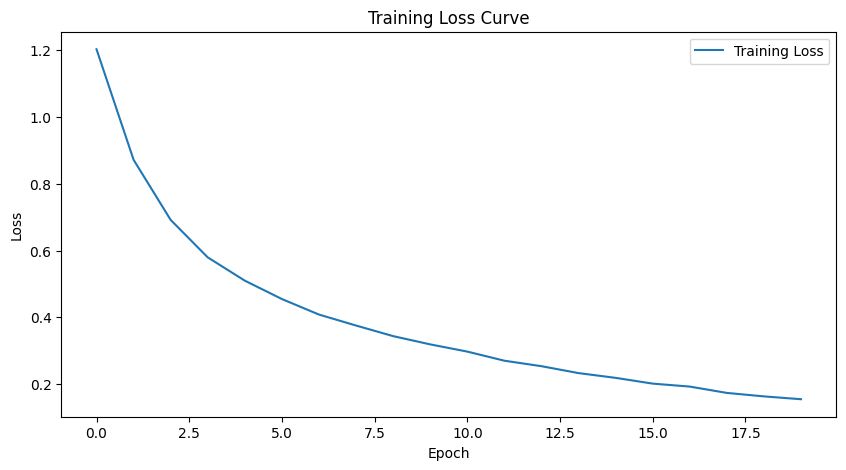

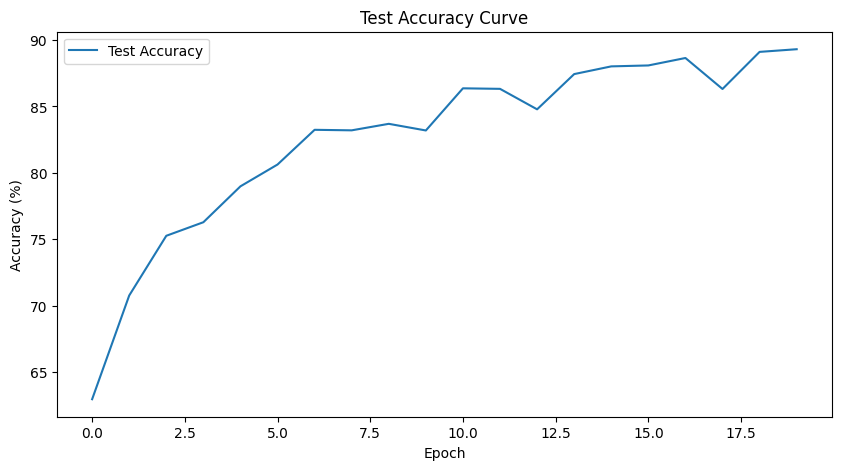

In [ ]:
# Plotting the loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Plotting the accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()
plt.show()

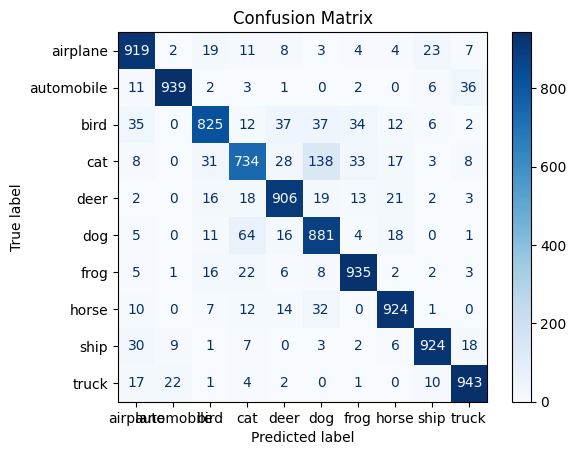

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Using Saved model for testing

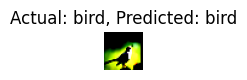

In [ ]:
# Load the model
model = ResNet18().to(device)
model.load_state_dict(torch.load('resnet18_cifar10.ckpt'))
model.eval()

# Get a random image from the test dataset
idx = np.random.randint(len(test_dataset))
image, label = test_dataset[idx]

# Predict the class label
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

# Display the image and predicted label
classes = test_dataset.classes
plt.figure(figsize=(0.5, 0.5))
plt.imshow(np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0)))
plt.title(f'Actual: {classes[label]}, Predicted: {classes[predicted_label]}')
plt.axis('off')
plt.show()